Figure List: 

Introduction/Motivation

1) Covariance Design 

2) FPR vs. FNR oracle

3) Marginalize over sparsity 

4) FPR vs. FNR BIC vs. R^2

5) Marginalize over sparsity (Effect of model selection)

6) Emerging selection frontier (with results plotted of correlation vs. SNR)

7) MSE coefficient estimation 

8) R2

9) Estimation bias

Future work (information theoretic selection fronteir)


### More specifically, given the three columns, there should be three major themes: 


# Plot of the different covariance designs and the coefficient distributions
 
#### 1) (a)Robustness of selection of different algorithms vs. increasing correlation strength (through a FPR v FNR plot and a margnilized 1D plot) 

#### 2) Importance of model selection criteria (show the difference between BIC and R2)
#### Through 2D plots, highlight the difference in the performance of algorithms using different selection criteria
#### (b) Can have good R^2 and even (total) L2 estimation error even with poor selection
#### (c) Nevertheless, highlight low bias and low variance of UoI estimates on the correctly selected model support

#### (3) Emerging numerical characterization of a selection frontier. Here we need to plot an error probability of partial support recovery across 3 parameters - SNR, average correlation, and the number of samples

In [23]:
# In light of these requirements, we need to put together the 1D and 2D plotters for arbitrary x and y, as well
# as 1 and 2D error probability plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
lasso_engine = sqlalchemy.create_engine('sqlite:///lasso.db')
lasso_con = lasso_engine.connect()
mcp_engine = sqlalchemy.create_engine('sqlite:///scad.db')
mcp_con = mcp_engine.connect()
scad_engine = sqlalchemy.create_engine('sqlite:///mcp.db')
scad_con = scad_engine.connect()

In [4]:
# These guys are small enough to live in memory
lasso = pd.read_sql_table('pp_df', lasso_con)
mcp = pd.read_sql_table('pp_df', mcp_con)
scad = pd.read_sql_table('pp_df', scad_con)

In [5]:
from plotting_utils import *

## FNR vs. FPR plots

In [6]:
kappa = np.unique(lasso['kappa'].values)
sparsity = np.unique(lasso['sparsity'].values)

In [7]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]

In [8]:
sparsity

array([0.02      , 0.02644752, 0.03497357, 0.04624822, 0.06115754,
       0.08087327, 0.10694488, 0.14142136, 0.18701223, 0.2473005 ,
       0.32702428, 0.4324491 , 0.57186037, 0.7562145 , 1.        ])

In [9]:
lasso_ = apply_df_filters(lasso, sparsity = sparsity[14])

In [10]:
lasso_.shape

(432000, 27)

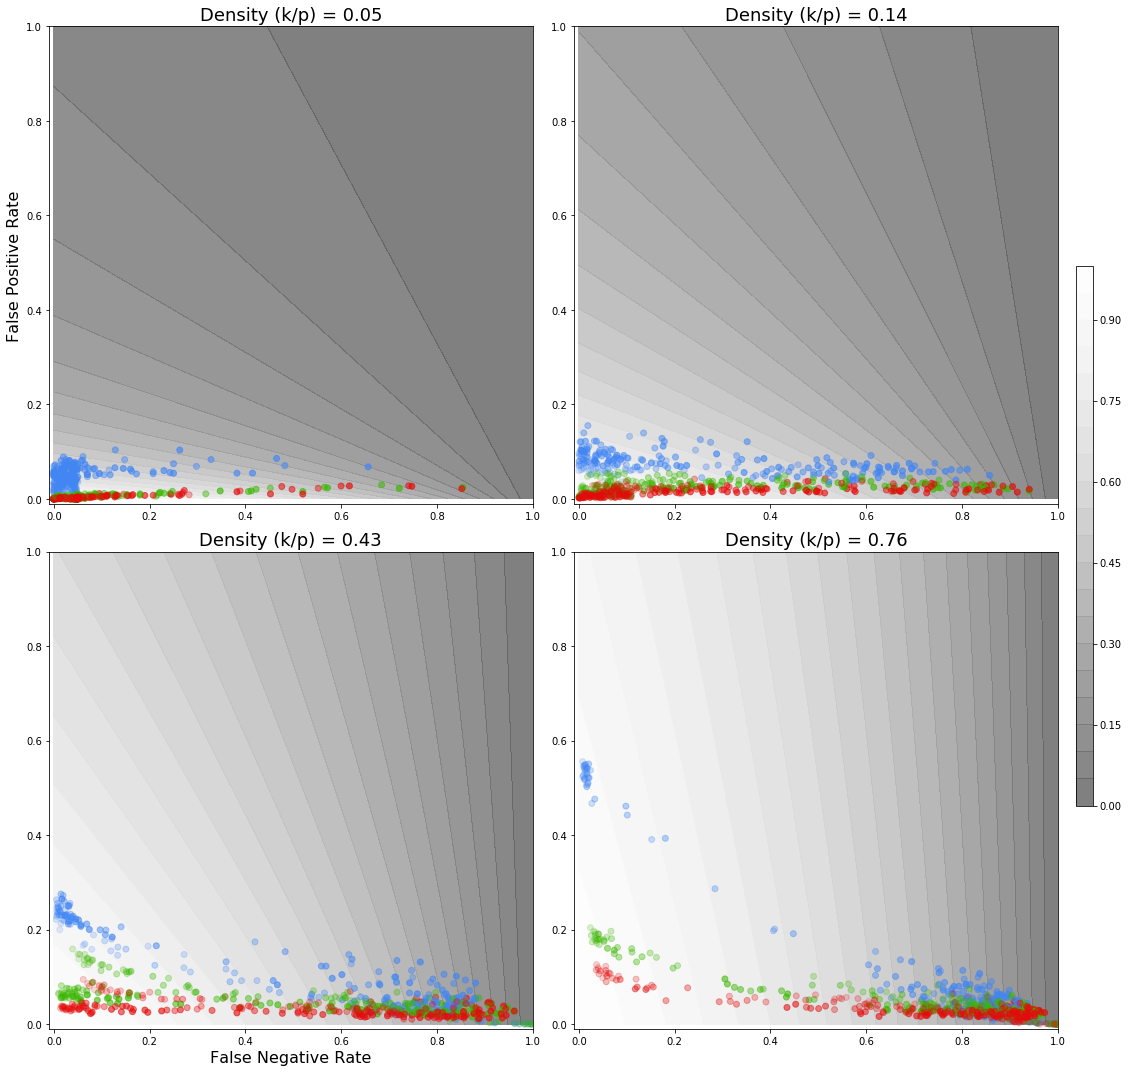

In [22]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))
scatters = []
n_features = 500
sparsity_ = [sparsity[3], sparsity[7], sparsity[11], sparsity[13]]
kappa_ = [5, 2, 1]
# Fix the number of samples!
np_ratio = 4
dframes = [lasso, mcp, scad]
selection_method = 'BIC'

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Superimpose contours of constant selection accuracy
    xx = np.linspace(0, 1, 100)
    yy = np.linspace(0, 1, 100)
    z = np.zeros((100, 100))
    for ix, x in enumerate(xx):
        for iy, y in enumerate(yy):
            z[ix, iy] = 1 - ((1 - s)* y + s * x)/(s * (2 - x - y) + y) 
    
    cmap = plt.get_cmap('Greys_r')
    cmap_new = truncate_colormap(cmap, minval = 0.25)
    cs = a.contourf(xx, yy, z.T, 20, cmap = cmap_new, alpha = 0.75)

    # Set opacity via average correlation    
    for j, k in enumerate(kappa_):
        for ii, bw in enumerate([-1]):   
            for cidx, df in enumerate(dframes):
                fil_df = apply_df_filters(df, sparsity=s, selection_method = selection_method, 
                                                kappa = k, betawidth=bw, np_ratio=np_ratio)
                a, scat = FNR_FPR_scatter(a, fil_df, cols[cidx])
        
    a.set_xlim([-0.01, 1])
    a.set_ylim([-0.01, 1])
    a.set_title('Density (k/p) = %.2f' % s, fontsize = 18)

ax[0, 0].set_ylabel('False Positive Rate', fontsize = 16)
ax[1, 0].set_xlabel('False Negative Rate', fontsize = 16)
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(cs, cax = cax)
plt.tight_layout()
# plt.savefig('fprvfnr_BIC.pdf', bbox_inches = 'tight', pad_inches=0)

In [ ]:
## ^ Interesting difference between betawidth -1 and the other ones